# Post-processing of case studies

In [1]:
import os
import cases

import matplotlib.pyplot as plt

from buildingspy.io.outputfile import Reader
from buildingspy.io.postprocess import Plotter

In [3]:
cases.get_case('annual_base')

{'model': 'Buildings.Examples.VAVReheat.ASHRAE2006',
 'name': 'annual_base',
 'start_time': 0,
 'stop_time': 31536000}

In [221]:
# Read data
winter=0
spring=1
summer=2
r_base=list()
r_base_annual=Reader(cases.get_result_file_name('annual_base'), "dymola")
r_base.insert(winter, Reader(cases.get_result_file_name('winter_base'), "dymola"))
r_base.insert(spring, Reader(cases.get_result_file_name('spring_base'), "dymola"))
r_base.insert(summer, Reader(cases.get_result_file_name('summer_base'), "dymola"))

r_g36=list()
r_g36_annual=Reader(cases.get_result_file_name('annual_g36'), "dymola")
r_g36.insert(winter, Reader(cases.get_result_file_name('winter_g36'), "dymola"))
r_g36.insert(spring, Reader(cases.get_result_file_name('spring_g36'), "dymola"))
r_g36.insert(summer, Reader(cases.get_result_file_name('summer_g36'), "dymola"))

**** ASHRAE2006
**** ASHRAE2006
**** ASHRAE2006
**** ASHRAE2006
**** Guideline36
**** Guideline36
**** Guideline36
**** Guideline36


## Room temperatures

In [223]:
def plot_room_temp(readers):
    ''' Main method that plots the results
    '''
    from buildingspy.io.outputfile import Reader
    import matplotlib.pyplot as plt
    import matplotlib

    # Optionally, change fonts to use LaTeX fonts
    #from matplotlib import rc
    #rc('text', usetex=True)
    #rc('font', family='serif')
    
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 6}
    matplotlib.rc('font', **font)
    
    plt.clf()    
    
    time_scale=86400.
    # Read results
    for i in [0, 1, 2]:
        (t, TOut) = readers[i].values("weaBus.TDryBul")
        t = t/time_scale
        
        TRoo = list()
        reader=readers[i]
        TRoo.insert(0, reader.values("flo.nor.air.vol.T")[1])
        TRoo.insert(1, reader.values("flo.wes.air.vol.T")[1])
        TRoo.insert(2, reader.values("flo.sou.air.vol.T")[1])
        TRoo.insert(3, reader.values("flo.eas.air.vol.T")[1])
        TRoo.insert(4, reader.values("flo.cor.air.vol.T")[1])
    
        TSetHea = reader.values("conVAVCor.TRooHeaSet")[1]
        TSetCoo = reader.values("conVAVCor.TRooCooSet")[1]
   
        # Plot figure
        #plt.subplot(2, 1, 1)
        ax = plt.subplot(3, 1, i+1)

        ax.plot(t, TOut-273.15,    'k', label='$T_{out}$', linewidth=0.5)
        ax.plot(t, TRoo[0]-273.15, 'b',  label='$T_{nor}$', linewidth=0.5)
        ax.plot(t, TRoo[1]-273.15, 'g',  label='$T_{wes}$', linewidth=0.5)
        ax.plot(t, TRoo[2]-273.15, 'r',  label='$T_{sou}$', linewidth=0.5)
        ax.plot(t, TRoo[3]-273.15, 'c',  label='$T_{eas}$', linewidth=0.5)
        ax.plot(t, TRoo[4]-273.15, 'g',  label='$T_{cor}$', linewidth=0.5)
    
        ax.patch.set_facecolor('mistyrose')    
        ax.fill_between(t, TSetHea-273.15, y2=TSetCoo-273.15, color='white')
    
        ax.set_xlabel('time [days]')
        ax.set_ylabel('temperature [$^\circ$C]')
    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))

        ax.set_xlim([min(t)+5, min(t)+12])
 
        ax.legend(loc='center right', ncol=1)

        ax.grid(True)

    return plt

# Create the plots
fig = plot_room_temp(r_base)
fig.savefig('{}.pdf'.format("base_TRoom"))

fig = plot_room_temp(r_g36)
fig.savefig('{}.pdf'.format("g36_TRoom"))
#    plt.savefig('{}.png'.format(title))

# Energy consumption

In [289]:
def plot_energy(r_base, r_g36):
    from buildingspy.io.outputfile import Reader
    import matplotlib.pyplot as plt
    import matplotlib
    
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 10}
    matplotlib.rc('font', **font)
    
    plt.clf()    

    # Conversion to kWh/m2
    conv = 1/3600./1000.
    readers = [r_base, r_g36]
    width = 0.5       # the width of the bars: can also be len(x) sequence

    hea    = [0., 0.]
    cooSen = [0., 0.]
    cooLat = [0., 0.]
    fan    = [0., 0.]
    cooLatBas = [0., 0.]
    fanBas = [0., 0.]
    
    idx = [0, 1]
    for i in idx:
        hea[i]    =  readers[i].values('res.EHea')[1][-1] * conv
        cooSen[i] = -readers[i].values('res.ECooSen')[1][-1] * conv
        cooLat[i] = -readers[i].values('res.ECooLat')[1][-1] * conv
        fan[i]    =  readers[i].values('res.EFan')[1][-1] * conv
        cooLatBas[i] = hea[i] + cooSen[i]
        fanBas[i]    = cooLatBas[i] + cooLat[i]
        
    p1 = plt.bar(idx, hea, width, color='r')
    p2 = plt.bar(idx, cooSen, width, bottom=hea, color='g')
    p3 = plt.bar(idx, cooLat, width, bottom=cooLatBas, color='b')
    p4 = plt.bar(idx, fan,    width, bottom=fanBas, color='k')
        
    plt.ylabel('energy use [kWh/m2]')
    plt.xticks([0+width/2., 1+width/2.], ('base case', 'guideline 36'))
    #plt.yticks(np.arange(0, 81, 10))
    plt.legend((p1[0], p2[0], p3[0], p4[0]), \
               ('heating', 'sensible cooling', 'latent cooling', 'fan'), \
              loc='top')
    
    
    fig.savefig('{}.pdf'.format("energy"))
plot_energy(r_base_annual, r_g36_annual)

## Diagnostics

In [292]:
print("Average outdoor air intake, base {} kg/s".format(r_base_annual.mean('eco.port_Out.m_flow')))
print("Average outdoor air intake, G36  {} kg/s".format(r_g36_annual.mean('eco.port_Out.m_flow')))

Average outdoor air intake, base 1.07357783343 kg/s
Average outdoor air intake, G36  0.948795643444 kg/s


In [ ]:
(t, y) = r_base_annual.values('flo.sou.air.vol.T')
plt=Plotter.boxplot(t=t, y=y-273.15, increment=3600, nIncrement=24)

# Decorate, save and show the plot
plt.xlabel('Time [h]') 
plt.ylabel(u'Room temperature [$^\circ$C]') 
plt.grid()
plt.savefig("roomTemperatures.png")
plt.savefig("roomTemperatures.pdf")
plt.title('South zone, base case')
plt.show() 

## Energy use

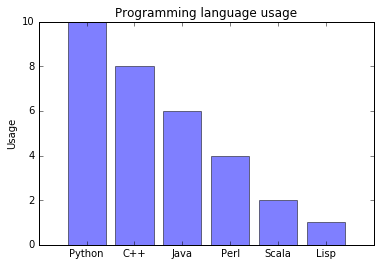